[[837923.52554085 837923.52554085 837923.52554085 ... 837923.52554085
  837923.52554085 837923.52554085]
 [837923.52554085 837923.52554085 837923.52554085 ... 837923.52554085
  837923.52554085 837923.52554085]
 [837923.52554085 837923.52554085 837923.52554085 ... 837923.52554085
  837923.52554085 837923.52554085]
 ...
 [837923.52554085 837923.52554085 837923.52554085 ... 837923.52554085
  837923.52554085 837923.52554085]
 [837923.52554085 837923.52554085 837923.52554085 ... 837923.52554085
  837923.52554085 837923.52554085]
 [837923.52554085 837923.52554085 837923.52554085 ... 837923.52554085
  837923.52554085 837923.52554085]]


/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


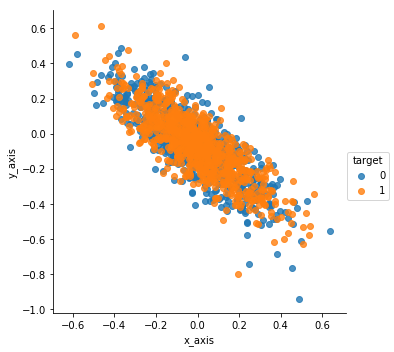

/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/pandas/core/dtypes/cast.py:636: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype)
/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:769: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:2052: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


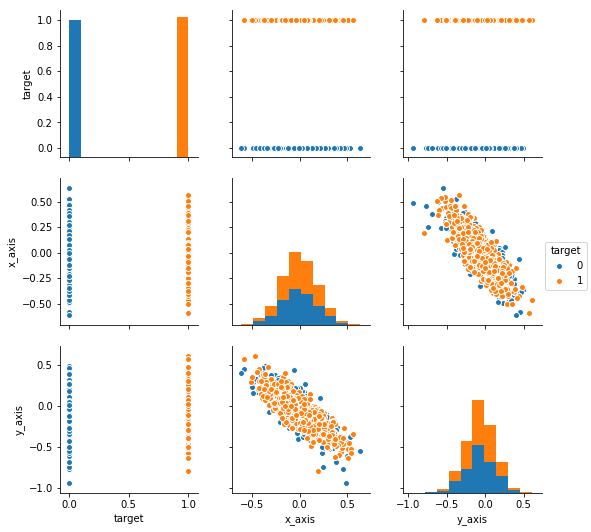

In [2]:
import os
import json
import numpy as np
import pandas as pd
from numpy import linalg
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
def getKey(item):
    return item[0]

def pool_sentence_embs(path, pooling_layer=-1, pooling_strategy='mean'):
    embs = []
    sents = []
    with open(path, 'r') as f:
        for line in f.readlines():
            line = line.strip()
            dic = json.loads(line)
            token_embs = []
            tokens = []
            for index in range(len(dic['features'])): #index is word in sent
                token_embs.append(dic['features'][index]['layers'][pooling_layer]['values'])
                tokens.append(dic['features'][index]['token'])
            sents.append(" ".join(tokens))
            token_embs = np.asarray(token_embs) #length of sentence X hidden dimension 768
            if pooling_strategy == "mean":
                embs.append(token_embs.mean(0))

        embs = np.asarray(embs)
        #print(embs.shape)
        #print (sents)
    return embs
            # sent = dic[]


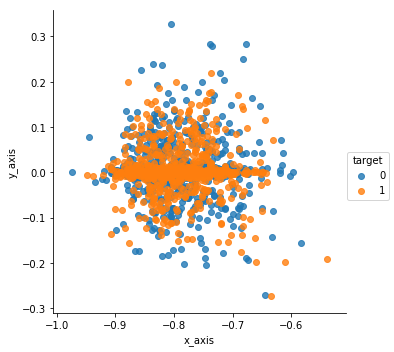

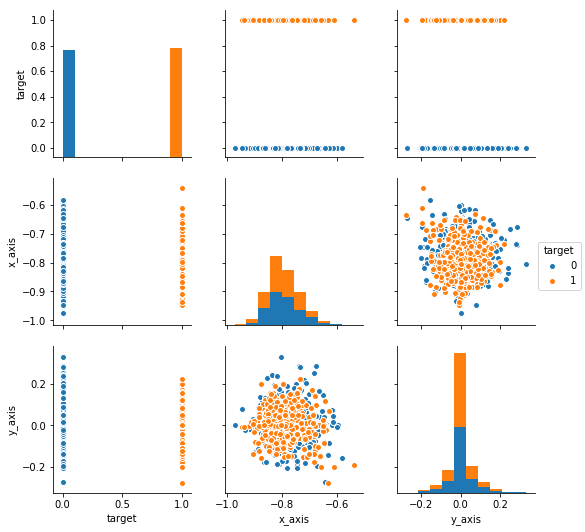

In [24]:

def main(path):
    embs = pool_sentence_embs(path)[1:]
    df = pd.read_csv('plotting_test_gutenberg.csv', encoding ='utf - 8', index_col = False)
    target = df['label'].values
    
    mean = np.mean(embs, axis=0)
    overall_mean = np.mean(embs, axis=1).mean()    

    scatter_matrix = np.zeros((embs.shape[1],embs.shape[1]))
    btw_scatter_matrix = np.zeros((embs.shape[1],embs.shape[1]))

    alpha = 2
    for i in range(embs.shape[1]):
        scatter_matrix += (embs[i,:].reshape(768,1)-mean).dot((embs[i,:].reshape(768,1)-mean).T)
    btw_scatter_matrix += embs.shape[0] * (mean - overall_mean).dot((mean - overall_mean).T)
    regularized_covariances = alpha * btw_scatter_matrix + (1-alpha) * scatter_matrix

    #e_vals, e_vecs = np.linalg.eig(np.linalg.inv(scatter_matrix).dot(btw_scatter_matrix))

    e_vals, e_vecs = np.linalg.eig(regularized_covariances)
    e_vals = sorted(e_vals, reverse=True)
    e_pairs = [(np.abs(e_vals[i]), e_vecs[:,i]) for i in range(len(e_vals))]
    e_pairs = sorted(e_pairs, key=getKey, reverse=True)
    
    W = np.hstack((e_pairs[0][1].reshape(embs.shape[1],1), e_pairs[1][1].reshape(embs.shape[1],1)))
    lda = embs.dot(W)
    
    x_axis, y_axis = lda[:,0], lda[:,1]
    
    data = {'x_axis':x_axis,'y_axis':y_axis,'target':target}
    data = pd.DataFrame(data)
    
    graph = sns.lmplot(data=data, x = 'x_axis', y = 'y_axis', hue = 'target',  fit_reg=False )
    plt.show()
    
    pairplot = sns.pairplot(data, hue='target')
    plt.show()
    
    
if __name__ == '__main__':
    main('plot.json')